In [1]:
import numpy as np
import scipy as sp
import scipy.interpolate as sinterp
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import PIL
import time



In [2]:
# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')


# plt.rc('text', usetex=True)
# font = {'family' : 'serif',
#         'weight' : 'bold',
#         'size'   : 20}
font = {'size'   : 14}
mpl.rc('font', **font)


output_path = './figures/'



In [23]:
class SimPSFToolkit(object):
    """Simulate PSFs.
    
    In the future the zernike maps could be created with galsim.
    
    Parameters
    ----------
    zernike_maps
    pad_factor=2
    max_order=45
    max_wfe: float
        Maximum allowed WFE at ``lambda_norm``. Used for
        normalization. Units in [\mu m].
        Default is ``0.1``.
    lambda_norm: float
        Corresponds to the wavelength at which the normalization 
        of the WFE is taking place. Units in [\mu m].
        Default is ``0.550``.
    rand_seed=None
    plot_opt=True
    
    """
    
    def __init__(self, zernike_maps, max_order=45, max_wfe_rms=0.1,
                 output_dim=64, rand_seed=None, plot_opt=False, oversampling_rate=2,
                 pix_sampling=12, tel_diameter=1.2, tel_focal_length=24.5,
                 pupil_diameter=1024, verbose=0):
        # Input attributes
        self.max_order = max_order
        self.rand_seed = rand_seed
        self.plot_opt = plot_opt
        self.zernike_maps = zernike_maps
        self.max_wfe_rms = max_wfe_rms  # In [um]
        self.output_dim = output_dim  # In pixels per dimension
        self.verbose = verbose
        
        
        # Telescope characteristics
        self.oversampling_rate = oversampling_rate  # dimensionless
        self.pix_sampling = pix_sampling  # In [um]
        self.tel_diameter = tel_diameter  # In [m]
        self.tel_focal_length = tel_focal_length  # In [m]
        self.pupil_diameter = pupil_diameter  # In [pix]
        
        # Class attributes
        self.z_coeffs = None
        self.psf = None
        self.opd = None
        self.phase = None
        self.lambda_obs = None
        self.poly_psf = None
        
        # Generate pupil mask
        self.pupil_mask = ~np.isnan(self.zernike_maps[0])
        
        
    @staticmethod
    def _OLD_fft_diffraction_op(wf, pupil_mask, pad_factor=2, match_shapes=True):
        """ Perform a fft-based diffraction.

        Parameters
        ----------
        wf: np.ndarray
            A complex 2D array that corresponds to the wavefront function.
        pupil_mask: np.ndarray of bools
            A 2D boolean mask that corresponds to the pupil function.


        Returns
        -------
        psf: np.ndarray
            A real 2D array corresponding to the PSF.

        """
        start = (wf.shape[0]*pad_factor)//2 - wf.shape[0]//2
        stop = (wf.shape[0]*pad_factor)//2 + wf.shape[0]//2

        padded_wf = np.zeros((wf.shape[0]*pad_factor, wf.shape[1]*pad_factor), dtype=np.complex128)

        padded_wf[start:stop, start:stop][pupil_mask] = wf[pupil_mask]

        fft_wf = np.fft.fftshift(np.fft.fft2(padded_wf))
#         fft_wf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(padded_wf)))
        
        psf = np.abs(fft_wf)**2
        
        if match_shapes:
            # Return the psf with its original shape without the padding factor
            x_dif = int((psf.shape[0]/pad_factor)//2)
            y_dif = int((psf.shape[1]/pad_factor)//2)        

            return psf[x_dif :psf.shape[0]-x_dif, y_dif :psf.shape[1]-y_dif]
        else:
            return psf
    
    
    @staticmethod
    def fft_diffract(wf, output_dim=64):
        # Perform the FFT-based diffraction operation
        fft_wf = np.fft.fftshift(np.fft.fft2(wf))
        psf = np.abs(fft_wf)**2
        
        # Crop the image
        start = int(psf.shape[0]//2-output_dim//2)
        stop = int(psf.shape[0]//2+output_dim//2)        

        return psf[start:stop, start:stop]
        
    
    @staticmethod
    def crop_img(to_crop_img, ref_im):
        cent_x = int(to_crop_img.shape[0]//2)
        cent_y = int(to_crop_img.shape[1]//2)
        
        delta_x = int(ref_im.shape[0]//2)
        delta_y = int(ref_im.shape[1]//2)
        
        return to_crop_img[ cent_x-delta_x : cent_x+delta_x , cent_y-delta_y : cent_y+delta_y ]
        
    
    @staticmethod
    def decimate_im(input_im, decim_f):
        """Decimate image.
        
        Decimated by a factor of decim_f.
        Based on the PIL library using the default interpolator.
        
        """

        pil_im = PIL.Image.fromarray(input_im)
        (width, height) = (pil_im.width // decim_f, pil_im.height // decim_f)
        im_resized = pil_im.resize((width, height))

        return np.array(im_resized)
    
    
    @staticmethod
    def get_radial_idx(max_order=45):
        it=1
        radial_idxs = []

        while(len(radial_idxs)<=max_order):
            for _it in range(it):
                radial_idxs.append(it-1)

            it+=1

        return np.array(radial_idxs)

    
    @staticmethod
    def psf_plotter(psf, lambda_obs=0.000, cmap='gist_stern', save_img=False):
        fig = plt.figure(figsize=(18,10))
        
        ax1 = fig.add_subplot(131)
        im1 = ax1.imshow(psf, cmap=cmap, interpolation='None')
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im1, cax=cax, orientation='vertical')
        ax1.set_xticks([]);ax1.set_yticks([])
        ax1.set_title('PSF (lambda=%.3f [um])'%(lambda_obs))

        ax2 = fig.add_subplot(132)
        im2 = ax2.imshow(np.sqrt(abs(psf)), cmap=cmap, interpolation='None')
        divider2 = make_axes_locatable(ax2)
        cax2 = divider2.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im2, cax=cax2, orientation='vertical')
        ax2.set_title('sqrt PSF (lambda=%.3f [um])'%(lambda_obs))
        ax2.set_xticks([]);ax2.set_yticks([])

        ax3 = fig.add_subplot(133)
        im3 = ax3.imshow(np.log(abs(psf)), cmap=cmap, interpolation='None')
        divider3 = make_axes_locatable(ax3)
        cax3 = divider3.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im3, cax=cax3, orientation='vertical')
        ax3.set_title('log PSF (lambda=%.3f [um])'%(lambda_obs))
        ax3.set_xticks([]);ax3.set_yticks([])
        
        if save_img:
            plt.savefig('./PSF_lambda_%.3f.pdf'%lambda_obs, bbox_inches='tight')

        plt.show()

        
    @staticmethod
    def opd_phase_plotter(pupil_mask, opd, phase, lambda_obs, cmap='viridis', save_img=False):
        fig = plt.figure(figsize=(18,10))
        
        ax1 = fig.add_subplot(131)
        im1 = ax1.imshow(pupil_mask, interpolation='None')
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im1, cax=cax, orientation='vertical')
        ax1.set_title('Pupil mask')
        ax1.set_xticks([]);ax1.set_yticks([])

        vmax = np.max(abs(opd))
        ax2 = fig.add_subplot(132)
        im2 = ax2.imshow(opd, cmap=cmap, interpolation='None', vmin=-vmax, vmax=vmax)
        divider2 = make_axes_locatable(ax2)
        cax2 = divider2.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im2, cax=cax2, orientation='vertical')
        ax2.set_title('OPD [um]')
        ax2.set_xticks([]);ax2.set_yticks([])
        
        vmax = np.max(abs(np.angle(phase)))
        ax3 = fig.add_subplot(133)
        im3 = ax3.imshow(np.angle(phase), cmap=cmap, interpolation='None', vmin=-vmax, vmax=vmax)
        divider3 = make_axes_locatable(ax3)
        cax3 = divider3.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im3, cax=cax3, orientation='vertical')
        ax3.set_title('W phase [rad](wv=%.2f[um])'%(lambda_obs))
        ax3.set_xticks([]);ax3.set_yticks([])
        
        if save_img:
            plt.savefig('./OPD_lambda_%.3f.pdf'%lambda_obs, bbox_inches='tight')

        plt.show()

        
    def get_psf(self):
        if self.psf is not None:
            return self.psf
        else:
            print('No PSF has been computed yet.')

            
    def plot_psf(self, cmap='gist_stern', save_img=False):
        if self.psf is not None:
            self.psf_plotter(self.psf,self.lambda_obs, cmap, save_img)
        else:
            print('No PSF has been computed yet.')

            
    def plot_opd_phase(self, cmap='viridis', save_img=False):
        if self.opd is not None:
            self.opd_phase_plotter(self.pupil_mask, self.opd, self.phase, self.lambda_obs, cmap, save_img)
        else:
            print('No WF has been computed yet.')

            
    def gen_random_Z_coeffs(self, max_order=45, rand_seed=None):
        """ Generate a random set of Zernike coefficients.

        The coefficients are generated following a uniform law U~[-1,1] 
        divided by their radial zernike index. 
        Ex: u_i / r(i) (u_i is a realization of U)

        Parameters
        ----------
        max_order: int
            Maximum order of Zernike polynomials.
        rand_seed: int
            Seed for the random initialization.

        Returns
        -------
        rand_coeffs: list of floats
            List containing the random coefficients.

        """
        if rand_seed is not None:
            np.random.seed(rand_seed)

        rad_idx = self.get_radial_idx(max_order)
        rad_idx[0] = 1 
        
        z_coeffs = []

        for it in range(max_order):
            z_coeffs.append((np.random.rand()-0.5)*2./rad_idx[it])

        self.z_coeffs = z_coeffs

        
    def plot_z_coeffs(self, save_img=False):
        """Plot random Zernike coefficients."""
        if self.z_coeffs is not None:
            fig = plt.figure(figsize=(12,6))
            ax1 = fig.add_subplot(111)
            im1 = ax1.bar(np.arange(len(self.z_coeffs)), np.array(self.z_coeffs))
            ax1.set_xlabel('Zernike coefficients')
            ax1.set_ylabel('Magnitude')
            
            if save_img:
                plt.savefig('./Z_coeffs.pdf', bbox_inches='tight')
                
            plt.show()
        else:
            print('Random coeffs not generated.')
          

    def get_z_coeffs(self):
        """Get random coefficients"""
        if self.z_coeffs is not None:
            return self.z_coeffs
        else:
            print('Random coeffs not generated.')

            
    def set_z_coeffs(self, z_coeffs):
        """Set zernike coefficients."""
        if len(z_coeffs) == self.max_order:
            self.z_coeffs = z_coeffs
        else:
            print('Zernike coefficients should be of length %d'%(self.max_order))
     
    
    def normalize_zernikes(self, z_coeffs=None, max_wfe_rms=None):
        """Normalize zernike coefficients."""
        if max_wfe_rms is None:
            max_wfe_rms = self.max_wfe_rms
            
        # Calculate normalization factor
        wfe_rms = self.calculate_wfe_rms(z_coeffs=z_coeffs)
        mult_factor = max_wfe_rms / wfe_rms
        
        # Normalize Zernike coefficients and return them
        z_coeffs = [_z*mult_factor for _z in z_coeffs]
        
        return z_coeffs
    
    def calculate_wfe_rms(self, z_coeffs=None):
        """Calculate WFE rms from a set of zernike coefficients."""
        if z_coeffs is None:
            if self.z_coeffs is None:
                self.gen_random_Z_coeffs(self.max_order, self.rand_seed)
                z_coeffs = self.get_z_coeffs()
            else:
                z_coeffs = self.get_z_coeffs()
                  
        # Create the phase with the Zernike basis
        opd = 0
        for it in range(self.max_order):
            opd += self.zernike_maps[it]*z_coeffs[it]
            
        # Calculate normalization factor
        wfe_rms = np.sqrt(np.mean((opd[self.pupil_mask] -np.mean(opd[self.pupil_mask]))**2))
        
        return wfe_rms
    
    def check_wfe_rms(self, z_coeffs=None, max_wfe_rms=None):
        """Check if Zernike coefficients are within the maximum admitted error."""
        
        if max_wfe_rms is None:
            max_wfe_rms = self.max_wfe_rms
        
        # Calculate normalization factor
        wfe_rms = self.calculate_wfe_rms(z_coeffs=z_coeffs)
        
        return max_wfe_rms - wfe_rms
        
        
    def generate_mono_PSF(self, lambda_obs=0.725, regen_sample=False, get_psf=False):
        """Generate monochromatic PSF."""
        if lambda_obs<0.55 or lambda_obs>0.9:
            print('WARNING: requested wavelength %.4f um is not in VIS passband [0.55,0.9]um'%(lambda_obs))
        self.lambda_obs = lambda_obs
        
        # Calculate the OPD from the Zernike coefficients
        self.calculate_opd(regen_sample)
          
        # Apply the diffraction operator using the opd (optical path differences)
        self.diffract_phase()
        
        if get_psf is True:
            return np.copy(self.psf)
    
    def calculate_opd(self, regen_sample=False):
        """Calculate the OPD from the Zernike coefficients."""
        if self.z_coeffs is None or regen_sample is True:
            # Generate a random sample of coefficients
            self.gen_random_Z_coeffs(self.max_order, self.rand_seed)
            # Normalize coefficients
            z_coeffs = self.normalize_zernikes(self.get_z_coeffs(), self.max_wfe_rms)
            # Save coefficients
            self.set_z_coeffs(z_coeffs)  
            # Plot Zernike coefficients
            if self.plot_opt:
                self.plot_z_coeffs()

        else:
            # Get the stored Zernike coefficients
            z_coeffs = self.get_z_coeffs()
            
        
        # Create the phase with the Zernike basis
        opd = 0
        for it in range(self.max_order):
            opd += self.zernike_maps[it]*z_coeffs[it]
        
        # Save the wavefront
        self.opd = opd
        
    
    def diffract_phase(self, lambda_obs=None):
        """Diffract the phase map."""
        if lambda_obs is None:
            if self.lambda_obs is None:
                print('WARNING: No wavelength is defined. Using default value 0.8um.')
                lambda_obs = 0.8
            else: 
                lambda_obs = self.lambda_obs
        elif lambda_obs<0.55*0.99 or lambda_obs>0.9*1.01:
            print('WARNING: wavelength %.4f is not in VIS passband [0.55,0.9]um'%(lambda_obs))
            
        # Calculate the feasible lambda closest to lambda_obs
        possible_lambda = self.feasible_wavelength(lambda_obs)
        
        # Save wavelength
        self.lambda_obs = possible_lambda
        
        # Calculate the required N for the input lambda_obs
        possible_N = self.feasible_N(self.lambda_obs)
        
        # Generate the full phase and
        # Add zeros to the phase to have the correct fourier sampling
        start = possible_N//2 - self.opd.shape[0]//2
        stop = possible_N//2 + self.opd.shape[0]//2

        self.phase = np.zeros((possible_N, possible_N), dtype=np.complex128)
        self.phase[start:stop, start:stop][self.pupil_mask] = np.exp(
            2j*np.pi*self.opd[self.pupil_mask]/self.lambda_obs)
        
        # FFT-diffract the phase (wavefront) and then crop to desired dimension
        self.psf = self.fft_diffract(wf=self.phase, output_dim=self.output_dim)
        
        # Normalize psf
        self.psf /= np.sum(self.psf)

        
    def feasible_N(self, lambda_obs):
        """Calculate the feasible N for a lambda_obs diffraction.
        
        Input wavelength must be in [um].
        """
        # Calculate the required N for the input lambda_obs
        req_N = (
            self.oversampling_rate * self.pupil_diameter * lambda_obs * self.tel_focal_length)/ (
            self.tel_diameter * self.pix_sampling)
        # Recalculate the req_N into a possible value (a pair integer)
        possible_N = int((req_N//2)*2)
        
        return possible_N
    
    def feasible_wavelength(self, lambda_obs):
        """Calculate closest fesible wavelength to target wavelength.
        
        Input wavelength must be in [um].
        """
        # Calculate a feasible N for the input lambda_obs
        possible_N = self.feasible_N(lambda_obs)
        
        # Recalculate the corresponding the wavelength
        possible_lambda = (
            possible_N * self.tel_diameter * self.pix_sampling) / (
            self.pupil_diameter * self.oversampling_rate * self.tel_focal_length)
        
        if self.verbose > 0:
            print("Requested wavelength: %.5f \nRequired N: %.2f"%(lambda_obs, req_N))
            print("Possible wavelength: %.5f \nPossible N: %.2f"%(possible_lambda, possible_N))
            
        return possible_lambda
 
    
    @staticmethod
    def gen_SED_interp(SED, n_bins=35, interp_kind='cubic'):
        """Generate SED interpolator.
        
        Returns the interpolator and the wavelengths in [nm].
        """
        wv_max = 900
        wv_min = 550
        wvlength = np.arange(wv_min, wv_max, int((wv_max-wv_min)/n_bins))
        
        SED_interp = sinterp.interp1d(
            SED[:,0], SED[:,1], kind=interp_kind, bounds_error=False, fill_value="extrapolate")
        
        return wvlength, SED_interp
 

    def generate_poly_PSF(self, SED, n_bins=35):
        """Generate polychromatic PSF with a specific SED.
        
        The wavelength space will be the Euclid VIS instrument band:
        [550,900]nm and will be sample in ``n_bins``.
        
        """
        # Generate SED interpolator and wavelengtyh array
        wvlength, SED_interp = self.gen_SED_interp(SED, n_bins)
        
        # Convert wavelength from [nm] to [um]
        wvlength_um = wvlength/1e3
        
        # Calculate feasible wavelengths (in [um])
        verbose = self.verbose
        self.verbose = 0
        feasible_wv = np.array([self.feasible_wavelength(_wv) for _wv in wvlength_um])
        self.verbose = verbose
        
        # Interpolate and normalize SED
        SED_norm = SED_interp(feasible_wv*1e3)  # Interpolation is done in [nm] 
        SED_norm /= np.sum(SED_norm)       
        
        # Plot input SEDs and interpolated SEDs
        if self.plot_opt:
            fig = plt.figure(figsize=(14,8))
            ax1 = fig.add_subplot(111)
            ax1.plot(SED[:,0],SED[:,1], label='Input SED')
            ax1.scatter(feasible_wv*1e3, SED_interp(feasible_wv*1e3), label='Interpolated', c='red')
            ax1.set_xlabel('wavelength [nm]')
            ax1.set_ylabel('SED(wavelength)')
            ax1.set_title('SED')
            ax1.legend()
            # plt.savefig(output_path+'SED_interp_nbin_%d.pdf'%n_bins, bbox_inches='tight')
            plt.show()
        
        stacked_psf = 0
        
        # Generate the required monochromatic PSFs
        for it in range(feasible_wv.shape[0]):          
            self.generate_mono_PSF(lambda_obs=feasible_wv[it])
            stacked_psf += self.get_psf()*SED_norm[it]
           
        self.poly_psf = stacked_psf
        
        return stacked_psf
    
# This pythonic version of the polychromatic calculation is not working
# The parallelisation with the class with shared variables might not be working
# It may work if we define a @staticmethod for the diffracvtion
#         psf_cube = np.array([_sed*self.generate_mono_PSF(_wv, get_psf=True) 
#                              for _wv, _sed in zip(feasible_wv, SED_norm)])
#         # Sum to obtain the polychromatic PSFs
#         self.poly_psf = np.sum(np_psf_cube, axis=0)
#         return np.copy(self.poly_psf)



# Simulating the variable frequency sampling 

In [24]:
# Fixed telescope parameters
pix_sampling=12
tel_diameter=1.2
tel_focal_length=24.5



# user parameters
oversampling_rate = 2

pupil_diameter = 1024


In [25]:
# First plot
req_N = lambda wavelength: (
    oversampling_rate * pupil_diameter * wavelength * tel_focal_length)/ (tel_diameter * pix_sampling)
Nyquist_N = 2*pupil_diameter


# Second plot
fixed_N = 2048
req_pupil_D = lambda wavelength: (tel_diameter * pix_sampling * fixed_N) / (oversampling_rate * wavelength * tel_focal_length)
Nyquist_pupil_D = fixed_N//2

# Sampling wavelengths
waves = np.linspace(0.55,0.9,350)



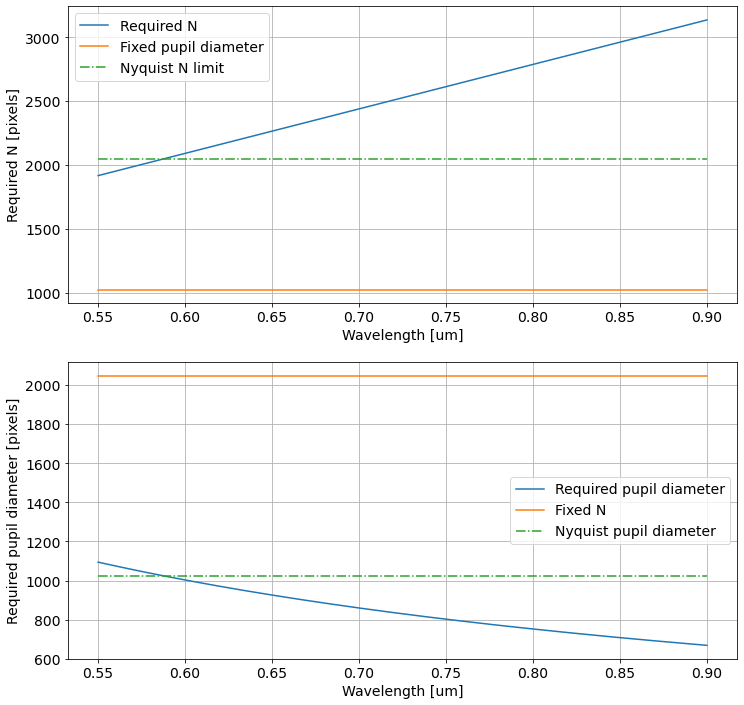

In [26]:
fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(211)
ax1.plot(waves,req_N(waves), label='Required N')
ax1.plot(waves,pupil_diameter*np.ones(waves.shape), label='Fixed pupil diameter')
ax1.plot(waves,Nyquist_N*np.ones(waves.shape), '-.', label='Nyquist N limit')
ax1.set_xlabel('Wavelength [um]')
ax1.set_ylabel('Required N [pixels]')
ax1.grid('minor')
ax1.legend()


ax2 = fig.add_subplot(212)
ax2.plot(waves,req_pupil_D(waves), label='Required pupil diameter')
ax2.plot(waves,fixed_N*np.ones(waves.shape), label='Fixed N')
ax2.plot(waves,Nyquist_pupil_D*np.ones(waves.shape), '-.', label='Nyquist pupil diameter')
ax2.set_xlabel('Wavelength [um]')
ax2.set_ylabel('Required pupil diameter [pixels]')
ax2.grid('minor')
ax2.legend()

# plt.savefig(output_path+'FFT_diffraction_N_pupil.pdf', bbox_inches='tight')

plt.show()



# Load the Zernike maps

In [27]:
Zcube_path = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/data/PA-zernike-cubes/Zernike45.mat'
Zcube = sio.loadmat(Zcube_path)
zernikes = []
for it in range(45):
    zernikes.append(Zcube['Zpols'][0,it][5])

# Monochromatic PSFs

In [28]:
# All parameters in default value
sim_PSF_toolkit = SimPSFToolkit(zernikes, max_order=45, max_wfe_rms=0.1, 
                                output_dim=64, rand_seed=None, plot_opt=True, oversampling_rate=2, 
                                pix_sampling=12, tel_diameter=1.2, tel_focal_length=24.5, 
                                pupil_diameter=1024, verbose=0)



### Generate a random sample of Zernike coefficients

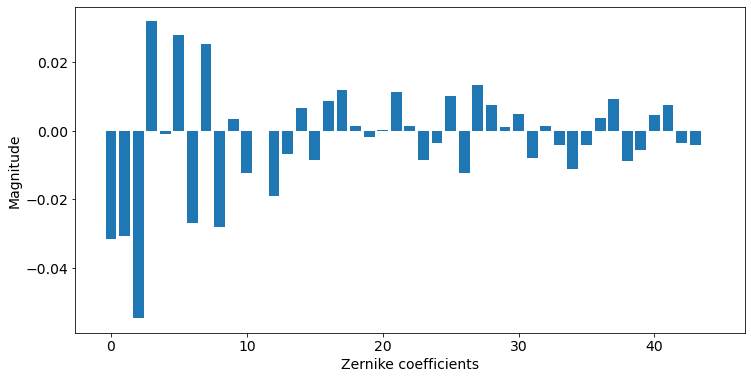

In [29]:
# Generate a random sample of coefficients
sim_PSF_toolkit.gen_random_Z_coeffs(max_order=45)
# Normalize coefficients
z_coeffs = sim_PSF_toolkit.normalize_zernikes(sim_PSF_toolkit.get_z_coeffs(), sim_PSF_toolkit.max_wfe_rms)
# Save coefficients
sim_PSF_toolkit.set_z_coeffs(z_coeffs)
# Plot Z coefficients
sim_PSF_toolkit.plot_z_coeffs(save_img=False)

### Generate monochromatic PSFs at different wavelengths

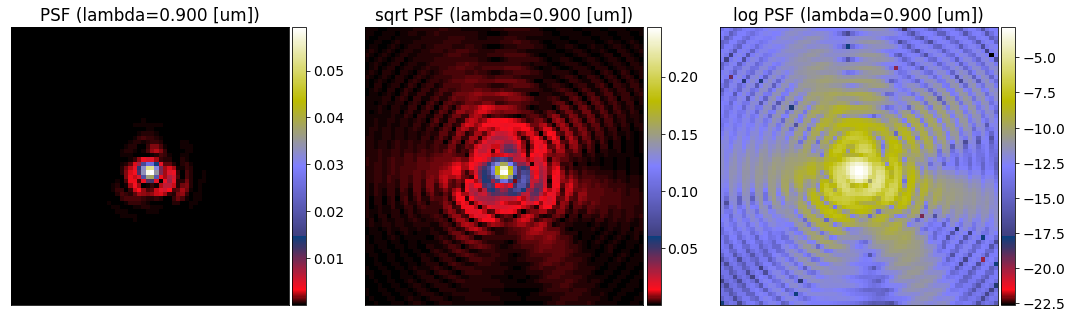

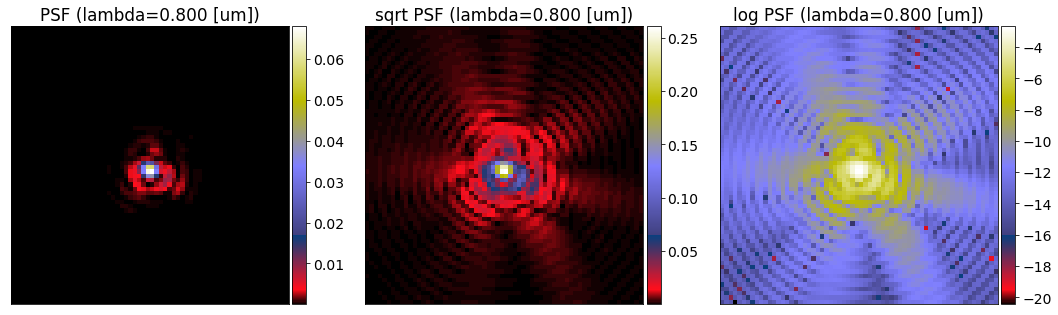

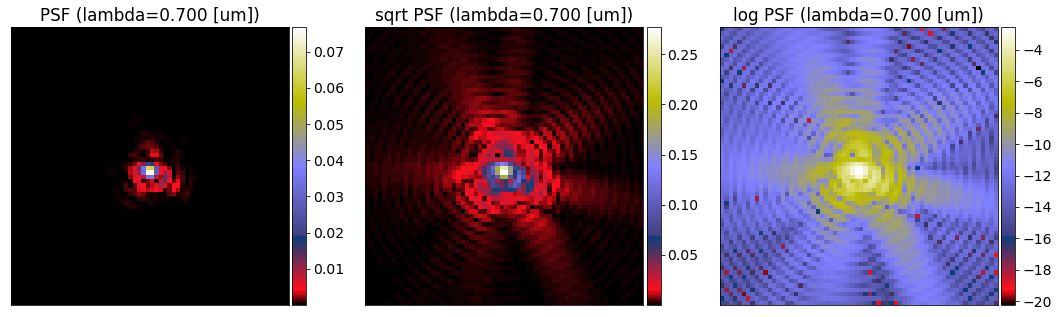

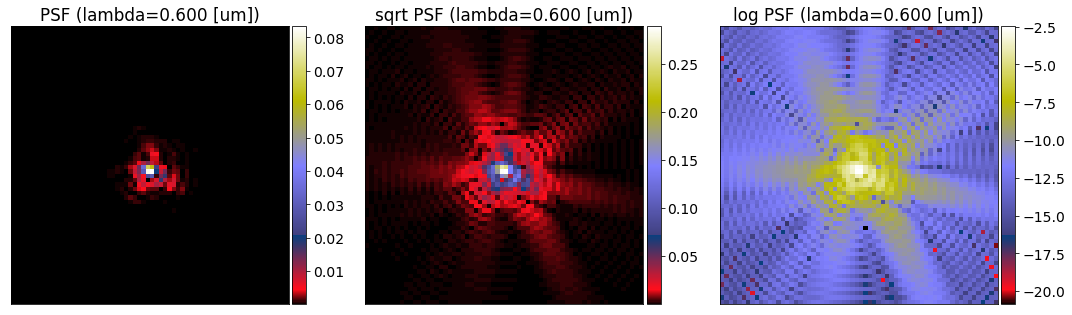

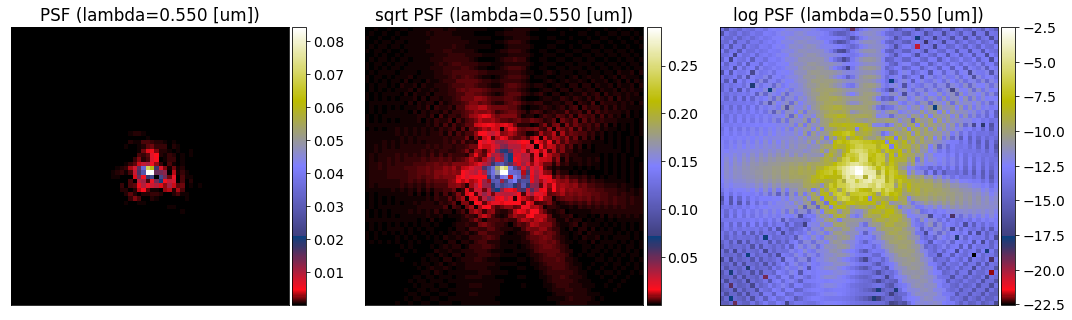

In [30]:
sim_PSF_toolkit.generate_mono_PSF(lambda_obs=0.9, regen_sample=False)
sim_PSF_toolkit.plot_psf(save_img=False)

sim_PSF_toolkit.generate_mono_PSF(lambda_obs=0.8, regen_sample=False)
sim_PSF_toolkit.plot_psf(save_img=False)

sim_PSF_toolkit.generate_mono_PSF(lambda_obs=0.7, regen_sample=False)
sim_PSF_toolkit.plot_psf(save_img=False)

sim_PSF_toolkit.generate_mono_PSF(lambda_obs=0.6, regen_sample=False)
sim_PSF_toolkit.plot_psf(save_img=False)

sim_PSF_toolkit.generate_mono_PSF(lambda_obs=0.55, regen_sample=False)
sim_PSF_toolkit.plot_psf(save_img=False)


### Inspect the wavefront 

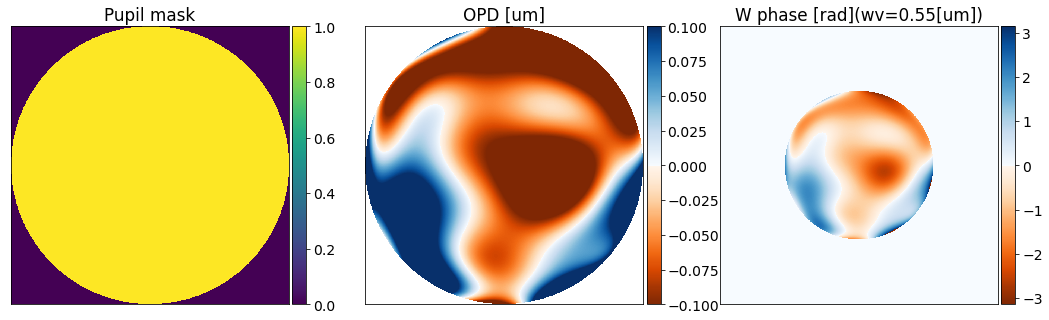

In [31]:
sim_PSF_toolkit.plot_opd_phase(newcmp, save_img=False)

# Polychromatic PSF

### Load an example SED

In [32]:
# Load the SED
SED_path = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/data/templatesCOSMOS/SB1_A_0_UV.sed'
PA_SED_path = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/data/PA-zernike-cubes/example_TSED.txt'

my_data = np.genfromtxt(SED_path,dtype=np.dtype('float64'))
euclid_band = np.copy(my_data)
euclid_band = euclid_band[euclid_band[:,0]>=500,:]
euclid_band = euclid_band[euclid_band[:,0]<=950,:]

PA_SED = np.genfromtxt(PA_SED_path,dtype=np.dtype('float64'))
PA_wvlength = np.arange(351)+550
PA_SED_wv = np.concatenate((PA_wvlength.reshape(-1,1), PA_SED.reshape(-1,1)), axis=1)



### Polychromatic PSF with 35 bins

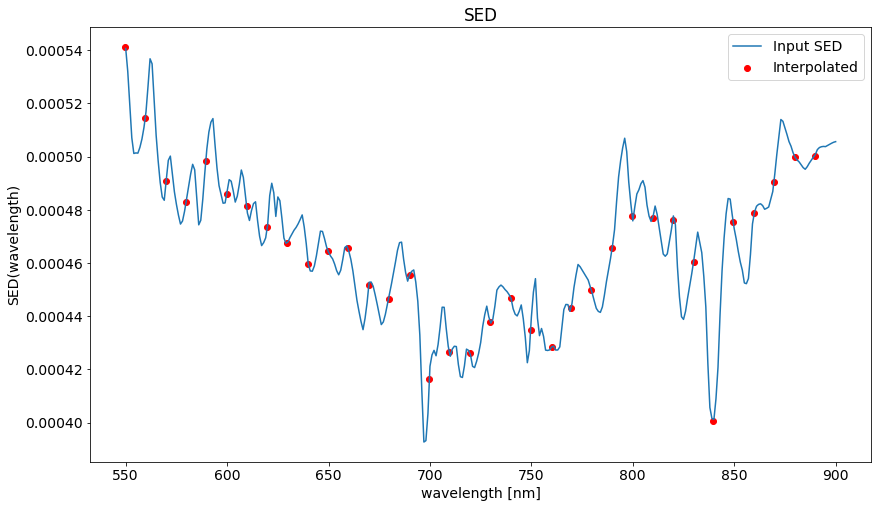

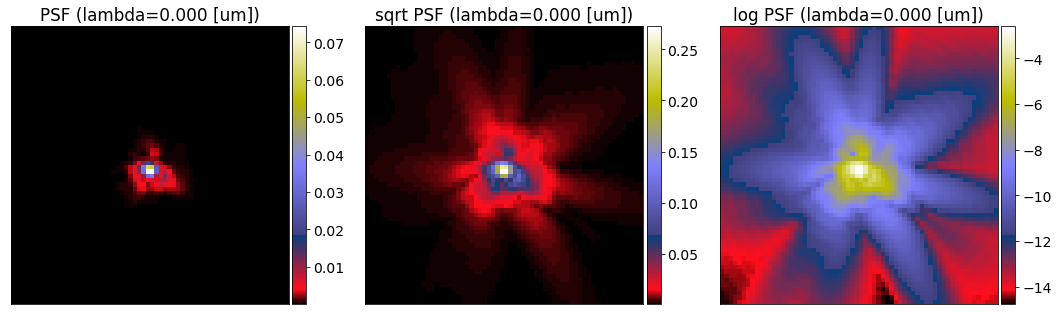

In [34]:
# Turn the plot option on
sim_PSF_toolkit.plot_opt = True
poly_psf_35 = sim_PSF_toolkit.generate_poly_PSF(PA_SED_wv, n_bins=35)
sim_PSF_toolkit.psf_plotter(poly_psf_35, lambda_obs=0.000, cmap='gist_stern',save_img=False)



### Polychromatic PSF with 100 bins

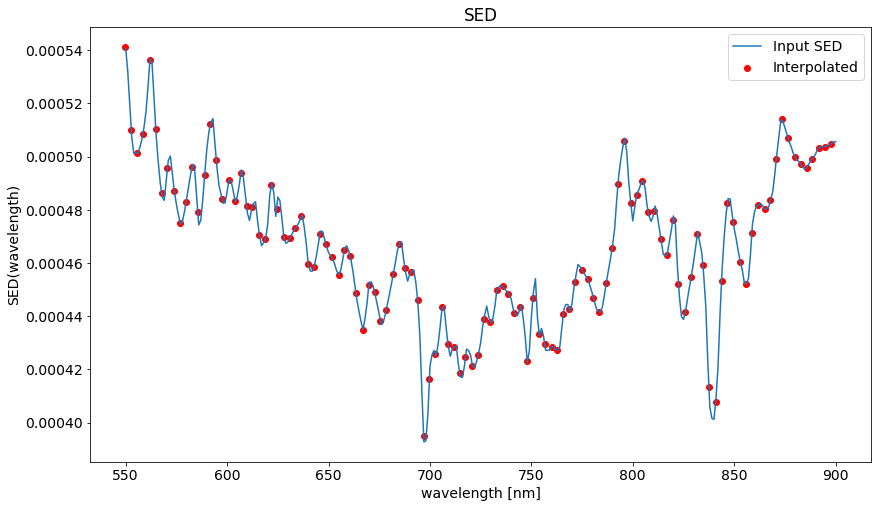

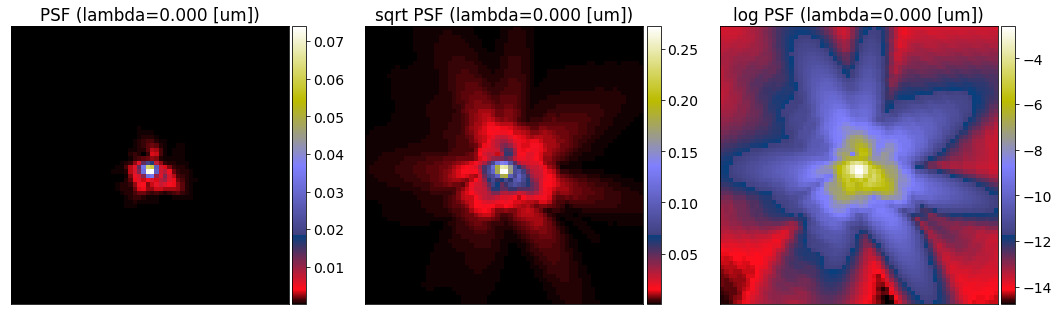

In [35]:
poly_psf_100 = sim_PSF_toolkit.generate_poly_PSF(PA_SED_wv, n_bins=100)
sim_PSF_toolkit.psf_plotter(poly_psf_100, lambda_obs=0.000, cmap='gist_stern',save_img=False)


## Residual between both PSFs

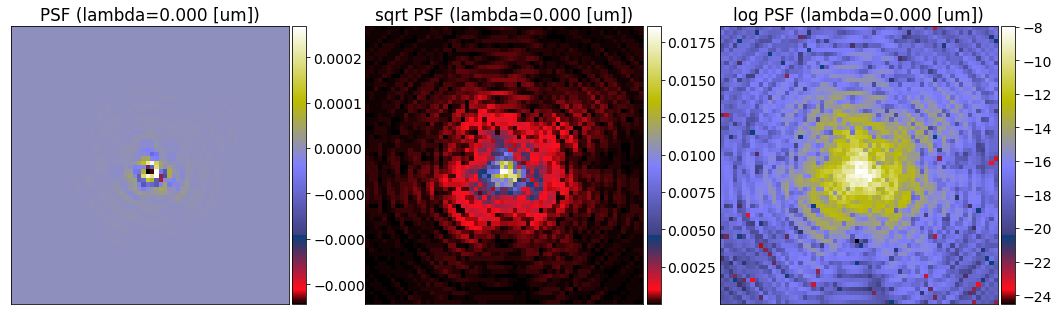

In [36]:
sim_PSF_toolkit.psf_plotter(poly_psf_100 - poly_psf_35, lambda_obs=0.000, cmap='gist_stern',save_img=False)

## Time PSF generation

In [16]:

sim_PSF_toolkit.plot_opt = False

n_bins = [5, 35, 100, 150]
times = []

for n  in range(len(n_bins)):
    times.append(0)
    for it in range(3):
        start_t = time.time()
        poly_psf = sim_PSF_toolkit.generate_poly_PSF(PA_SED_wv, n_bins=n_bins[n])
        end_t = time.time()
        times[n] += end_t - start_t
    
    times[n] /= 3
    

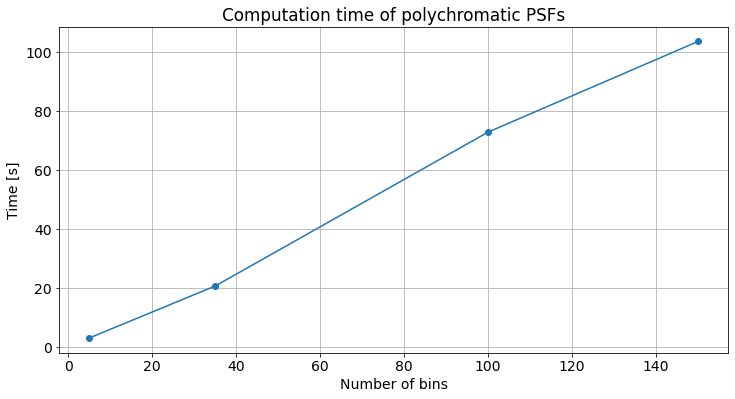

In [17]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)
ax1.plot(n_bins, times, 'o-')
ax1.set_xlabel('Number of bins')
ax1.set_ylabel('Time [s]')
ax1.set_title('Computation time of polychromatic PSFs')
ax1.grid('minor')
plt.savefig(output_path+'computation_time.pdf')
plt.show()